In [1]:
] activate .

  Activating project at `~/.julia/dev/HJB/examples`


In [2]:
] st

Status `~/.julia/dev/HJB/examples/Project.toml`
  [a6e380b2] ControlSystems v1.8.2
  [aaaaaaaa] ControlSystemsBase v1.9.6
  [0c46a032] DifferentialEquations v7.11.0
  [f6369f11] ForwardDiff v0.10.36
  [a3cb4e6c] HJB v1.0.0-DEV `~/.julia/dev/HJB`
  [6fe1bfb0] OffsetArrays v1.12.10
  [7f7a1694] Optimization v3.19.3
  [36348300] OptimizationOptimJL v0.1.13
  [91a5bcdd] Plots v1.39.0
  [49802e3a] ProgressBars v1.5.1
  [5d786b92] TerminalLoggers v0.1.7


In [3]:
using ProgressBars, HJB,  StaticArrays, LinearAlgebra, DifferentialEquations, Optimization, ForwardDiff, OptimizationOptimJL, Plots

Precompiling DifferentialEquations
  ✓ NonlinearSolve
  ✓ NonlinearSolve → NonlinearSolveBandedMatricesExt
  ✓ BoundaryValueDiffEq
  ✓ OrdinaryDiffEq
  ✓ DelayDiffEq
  ✓ StochasticDiffEq
  ✓ BoundaryValueDiffEq → BoundaryValueDiffEqOrdinaryDiffEqExt
  ✓ DifferentialEquations
  8 dependencies successfully precompiled in 225 seconds. 169 already precompiled.


In [4]:
using ControlSystemsBase

In [5]:
function smooth_min(a, b, k=3)
    # exponential smooth min
    res = exp( -k*a ) + exp( -k*b );
    return -log( res )/k;
end

function smooth_max(a, b, k=3)
    return (1/k) * log( exp(k*a) + exp(k*b))
end

smooth_max (generic function with 2 methods)

In [6]:
# define the dynamics
function f(t, x, u)
    return @SVector [x[2], u[1]]
end

# the cost function we want to minimize is 
# J(x, u) = 1/2 x_f Q_f x_f \int_0^T 1/2 x'Qx + 1/2 u'Ru

A = [[0;;1];[0;;0]]
B = [[0;;];[1;;]]
Q = 1.0 * I(2)
Qf = 1.0 * Q
R = 1.0 * I(1)


function HH(t, x, u, p)
    return p' * (A*x + B*u) + (1/2)*(x' * Q * x + u' * R * u)
end

function DxHH(t, x, u, p)
    return p'*A + x' * Q
end

# define the Hamiltonian
function H(t, x, V, DxV) # H(t, x, z, s)

    u = - inv(R) * B' * DxV

    return HH(t, x, u, DxV)
end

# define the constraint function
function σ(x)
    return 1/2 * (x' * Qf * x)
    return xcon
end

σ (generic function with 1 method)

In [7]:
HH(0.0, [0,0.], [1.0], [1.0, 1.0])

1.5

In [8]:
H(0.0, [0.0, 0.], 1.0, [1.0, 1.0]) 

-0.5

In [9]:
# t = 0.0
# x = [0.0, 1.0]
# V = 0.0
# s = randn(2)

# define all the derivatives
DxH(t, x, z, s) = ForwardDiff.gradient(xx -> H(t, xx, z, s), x)
DsH(t, x, z, s) = ForwardDiff.gradient(ss -> H(t, x, z, ss), s)

DxH!(r, t, x, z, s) = ForwardDiff.gradient!(r, xx -> H(t, xx, z, s), x)
DsH!(r, t, x, z, s) = ForwardDiff.gradient!(r, ss -> H(t, x, z, ss), s)

DzH(t, x, z, s) = ForwardDiff.derivative(zz -> H(t, x, zz, s), z)
Dσ(x) = ForwardDiff.gradient(σ, x)

Dσ (generic function with 1 method)

In [10]:
function characteristic_system!(D, state, params, t)
    N = 2 # dimension of the problem
    xinds = 1:N
    sinds = (N+1):(2N)
    zind = 2N + 1
    
    x = state[xinds] # state
    s = state[sinds] # costate
    z = state[zind] # characteristic

    D[xinds] = DsH(t, x, z, s) 
    D[sinds] = -DxH(t, x, z, s) - DzH(t, x, z, s)  * s
    D[zind] = dot(s, D[xinds]) - H(t, x, z, s)

    # DxH!(D[sinds], t, x, z, s)
    # DsH!(D[xinds], t, x, z, s)
    # D[sinds] .*= -1
    # D[sinds] -= DzH(t, x, z, s)*s

    return
end

characteristic_system! (generic function with 1 method)

In [11]:
function solve_ode(y)

    xθ = y
    sθ = Dσ(y)
    zθ = σ(y)

    stateθ = vcat(xθ, sθ, zθ)

    tspan = (1.0, 0.0)

    prob = ODEProblem(characteristic_system!, stateθ, tspan)

    sol = solve(prob, save_everystep=false, save_end=true)

    return sol

end

solve_ode (generic function with 1 method)

In [12]:
solve_ode([0.1, 0.])

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 1.0
 0.0
u: 2-element Vector{Vector{Float64}}:
 [0.1, 0.0, 0.1, 0.0, 0.005000000000000001]
 [0.07819474394609527, 0.07166388587138618, 0.19484129770459555, 0.17081071627158403, 0.013738225055497742]

In [13]:
function plot_grid!(data, grid::HJB.Grid{2, F}; kwargs...) where {F}
    # for now only supports plotting 2 dimensional problems

    x1s = HJB.getDomainAxes(grid, 1)
    x2s = HJB.getDomainAxes(grid, 2)

    heatmap!(x1s, x2s, data[HJB.DomainIndices(grid)]', kwargs...)

end

plot_grid! (generic function with 1 method)

In [14]:
x1s = -1:0.025:1
x2s = -2:0.025:2
grid = HJB.Grid((x1s, x2s))
value_function = HJB.allocate_grid(grid, x-> NaN);

In [37]:
count = 0
for i in ProgressBar(1:5000)
    # L = 2.5
    # y = 2L*rand(2) .- L
    y = 0.2*randn(2)
    sol = solve_ode(y)
    x0 = sol.u[end][1:2]
    z0 = sol.u[end][end]
    ind = HJB.state2ind(grid, x0)
    if ind in HJB.DomainIndices(grid)
        # value_function[ind] = nanmax(value_function[ind], z0)
        value_function[ind] = z0
        count += 1
        # @show i, x0, z0
    end
end
@show count

0.0%┣                                             ┫ 0/5.0k [00:00<00:00, -0s/it]
2.3%┣█                                        ┫ 115/5.0k [00:00<00:02, 2.2kit/s]
4.0%┣█▋                                       ┫ 200/5.0k [00:00<00:03, 1.9kit/s]
6.4%┣██▋                                      ┫ 318/5.0k [00:00<00:02, 2.0kit/s]
8.6%┣███▌                                     ┫ 430/5.0k [00:00<00:02, 2.1kit/s]
11.0%┣████▍                                   ┫ 548/5.0k [00:00<00:02, 2.1kit/s]
12.6%┣█████                                   ┫ 632/5.0k [00:00<00:02, 2.0kit/s]
15.0%┣██████                                  ┫ 750/5.0k [00:00<00:02, 2.1kit/s]
17.3%┣███████                                 ┫ 865/5.0k [00:00<00:02, 2.1kit/s]
19.7%┣███████▉                                ┫ 986/5.0k [00:00<00:02, 2.1kit/s]
21.7%┣████████▌                              ┫ 1.1k/5.0k [00:01<00:02, 2.1kit/s]
24.0%┣█████████▍                             ┫ 1.2k/5.0k [00:01<00:02, 2.1kit/s]
26.4%┣██████████▎           

count = 4969


96.6%┣█████████████████████████████████████▊ ┫ 4.8k/5.0k [00:02<00:00, 2.2kit/s]
99.0%┣██████████████████████████████████████▋┫ 4.9k/5.0k [00:02<00:00, 2.2kit/s]
100.0%┣██████████████████████████████████████┫ 5.0k/5.0k [00:02<00:00, 2.2kit/s]
100.0%┣██████████████████████████████████████┫ 5.0k/5.0k [00:02<00:00, 2.2kit/s]


4969

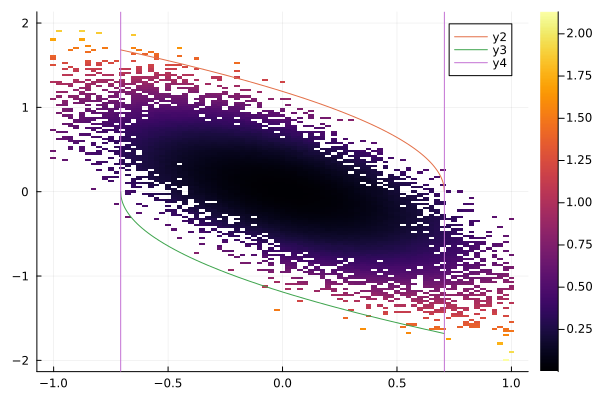

In [38]:
plot()
plot_grid!(value_function, grid)
# plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -1, sqrt(2)/2)
# vline!([sqrt(2)/2])
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p-> -sqrt(2 * 1 * (p + sqrt(2)/2)), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

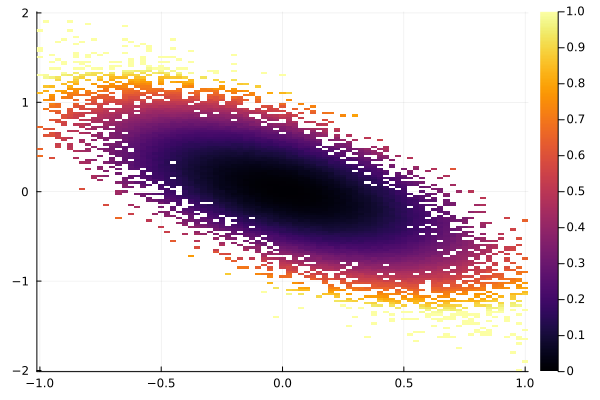

In [39]:
plot(clims=(0, 1))
plot_grid!(value_function, grid)

In [40]:
P = ControlSystemsBase.are(Continuous, A, B, Q, R)

2×2 Matrix{Float64}:
 1.73205  1.0
 1.0      1.73205

In [41]:
# P = ControlSystemsBase.are(Continuous, A, B, 2Q, R)

In [42]:
P

2×2 Matrix{Float64}:
 1.73205  1.0
 1.0      1.73205

In [43]:
true_clf = HJB.allocate_grid(grid, x-> 1/2 * x'*P*x);

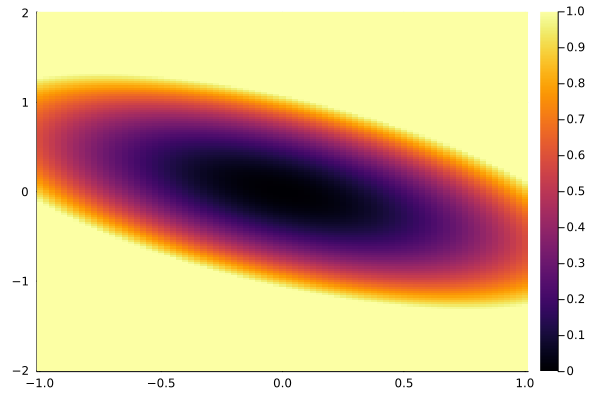

In [44]:
plot(clims=(0, 1))
plot_grid!(true_clf, grid)

In [45]:
err = abs.(true_clf .- value_function)

87×167 OffsetArray(::Matrix{Float64}, -3:83, -3:163) with eltype Float64 with indices -3:83×-3:163:
 0.0  0.0  0.0    0.0         0.0  …    0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0         0.0       0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0         0.0       0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN       NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN       NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN    …  NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN       NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN       NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN       NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN       NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN    …  NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN         NaN       NaN    NaN    NaN    0.0  0.0  0.0
 0.0  0.0  0.0  NaN     

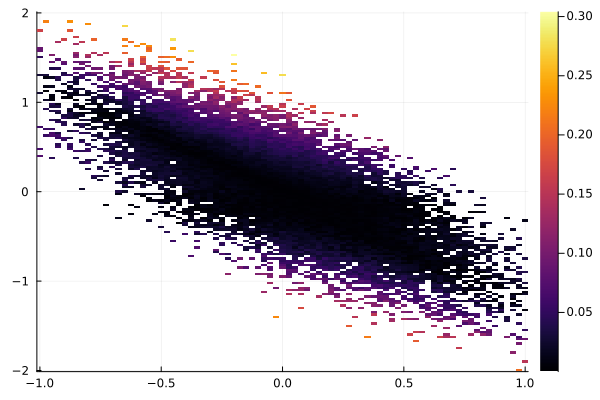

In [46]:
plot()
plot_grid!(err, grid)